In [1]:
import numpy as np
import cmath
import matplotlib.pyplot as plt
from scipy.optimize import fsolve
from sympy import symbols, Eq, solve
from scipy.integrate import odeint

In [2]:
def coefficients(e, c0, p0, Ka, Kc):
    d = c0**2 * e * Ka
    c = -c0**2 * Ka + c0 * e * (-2 * Ka + Kc) - c0 * Kc * p0
    b = -c0 * (-2 * Ka + Kc) + e * (Ka + (-1 + Kc) * Kc) - Kc * (-1 + 2 * Kc) * p0
    a = -Ka - (-1 + Kc) * Kc
    return(np.array([a, b, c, d]))

def  my_cubic_solve(array):
    roots = np.roots(array)
    real_roots = []
    for i in roots:
        if (i.imag == 0):
            real_roots.append(i.real)
    return (np.array(real_roots))

def tdmc(cp, c0, p0, Ka, Kc):
    c = c0  -  cp
    t = (cp**2  *  Kc**2  *  p0) / (c0**2 * Ka + c0 * cp * ( -2 * Ka + Kc) + cp**2 * (Ka + ( -1 + Kc) * Kc))
    d = ((c0 - cp) * cp * Kc * p0) / (c0**2 * Ka + c0 * cp * ( -2 * Ka + Kc) + cp**2 * (Ka + ( -1 + Kc) * Kc))
    m = ((c0 - cp)**2 * Ka * p0) / (c0**2 * Ka + c0 * cp * ( -2 * Ka + Kc) + cp**2 * (Ka + ( -1 + Kc) * Kc))
    return(t, d, m, c)

def equilibr_ck(k, c0, t, d):
    crp = c0 * t / (d * k + t)
    cr = c0 - crp
    return (cr, crp)

def tdm(p, z):
    atp = ( 3*z + p - (p*p + 6*p*z - 3*z*z)**0.5 ) / 6
    adp = z - 2*atp
    amp = p - z + atp
    return(atp, adp, amp)

def u_atpase(a, atp):
    return (a * atp)

def u_hk(a, atp, g6p):
	return (a * (atp/1) / (1 + atp/1 + g6p/0.0055))

def u_pgi(a, g6p, f6p):
	k1, k2, k3 = 3, 0.3, 0.2
	return (a * (g6p-f6p*k1)/k2/(1+g6p/k2+f6p/k3))

def u_pfk(a, atp, amp, f6p):
	az = (1+atp/0.195)/(1+amp/0.01)/(1+f6p/3.7e-4)
	zn = 1 + 1e8 * az**4
	ch = a * f6p / (f6p+0.1) * atp/(atp+2) * (1/(1+amp/0.01)+2*amp/(amp+0.01))
	return (1.1 * ch/zn)

def u_ald(a, fdp, dap, gap):
	k1, k2, k3 = 2e-4, 1.2e-5, 1e-2
	k4, k5, k6, k7 = 3.2e-2, 2.1e-3, 2, 6.5e-2
	x = fdp/k1 - dap*gap/k2
	y = 1 + fdp/k3 + dap/k4 + gap/k5 + fdp*dap/k3/k4 + dap*dap/k4/k6 + dap*gap/k4/k7
	return (a * x / y)
	# Aald_eff = Aald * k3 * k4 / (k1 * (DAP + k4))

def u_tpi(a, dap, gap):
	k1, k2, k3 = 8.2e-1, 0.45, 4.3e-1
	return (a*(dap-gap/k2)/k1/(1+dap/k1+gap/k3))

def u_gapd(a, gap, nad, pi, dpg13, nadh):
	k1, k2, k3 = 0.13, 0.13, 3.4
	k4, k5, k6 = 0.136, 1.25e-2, 2e-3
	tt1 = a * (gap*nad*pi - dpg13*nadh/k4)/k1/k2/k3
	tt2 = (1+pi/k3)*(1+gap/k1+dpg13/k5)*(1+nad/k2+nadh/k6)
	return (tt1/tt2)
	# Эффективная активность GAPD при данных NADH, NAD, PI в сторону образования 1,3ДФГ
	# Agapd_eff = (Agapd * k6 * NAD * PI) / (k6 * NAD + k2 * (k6 + NADH)) / (k3 + PI)

def u_pgk(a, dpg13, adp, pg3, atp):
	ch1 = a * (dpg13*adp - pg3*atp/380)/2.2E-3/0.14
	aa = (0.3 + adp + 0.3*atp/0.27) / 0.14
	ab = (0.4 + atp + adp*0.4/0.14) / 0.27
	zn1 = (1 + atp/0.27 + adp/0.14 + aa*dpg13/2.2E-3 + ab*pg3/1.4)
	return (ch1 / zn1)

def u_pgm(a, pg3, pg2):
	k1, k2, k3 = 0.27, 0.24, 2e-2
	return (a * (pg3 - pg2/k2) / k1 / (1 + pg3/k1 + pg2/k3))

def u_eno(a, pg2, pep):
	# Старый вариант из статьи Эрлих 1985. ЕНО здесь была практически необратимая
	# k1, k2, k3 = 5.6e-2, 6.7, 2e-3
	k1, k2, k3 = 28e-3, 5, 50e-3 # обновил параметры из литературы
	return (a * (pg2 - pep/k2) / k1 / (1 + pg2/k1 + pep/k3))

def u_pk(a, pep, adp, atp):
	k2 = 0.415
	ch = a * pep*adp/0.05/k2
	zn = 1 + pep/0.05 + adp/k2 + atp/0.35 + pep*adp/0.05/k2
	return (ch / zn)

def u_ld(a, pyr, nadh, lac, nad):
	k1, k2, k3 = 2.2e-2, 7e-3, 426
	k4, k5, k6, k7 = 1.4e-1, 380, 0.1, 170
	temp1 = (pyr*nadh - lac*nad/k3)/k1/k2
	temp2 = k7*nad + k6*lac + nad*lac + k7/k1*pyr*nad
	temp3 = 1 + pyr/k1 + (nadh*k4 + pyr*nadh + k4/k5*lac*nadh)/k1/k2 + temp2/k5/k6
	return (a * temp1/temp3)

def u_gp_a(a, pi, g1p):
	kp, kg, keq = 4, 2.7, 1/3
	# local keq = 1/12
	return (a * kg * (pi - g1p / keq) / (kg * kp + kg * pi + kp * g1p))


def u_gp_b(a, pi, g1p, amp):
	
	keq = 1/3 
	
	# local kp = 4 * (amp + 0.1) / 1.1 / amp
	# local kg = 2.7 * (amp + 0.1) / 2 / amp
	# local af = a * amp / (amp + 0.02)
	# return af * (pi * keq - g1p) / (kp * g1p + kg * pi + kp * kg)
	
	# local a, b = 7.2, 1.26
	# local c, d = 0.203, 0.7
	# local e, f = 22.7, 0.0139
	# local kp = a / amp + b
	# local kg = c / amp + d
	# local ar = e * amp / (amp + f)
	# local arn = ar / e
	# return a * arn * kp * (keq * pi - g1p) / (kp * g1p + kg * pi + kp * kg) 

	kg = 0.172 / amp + 1.11
	ar = amp / (amp + 0.0104)
	return (ar / kg * ( keq * pi - g1p ))



def u_pgcm(a, g1p, g6p):
	k1, k6, keq = 8.5e-3, 50e-3, 17
	return (a * k6 * (g1p - g6p / keq) / (k1 * k6 + k6 * g1p + k1 * g6p))

def u_gp_a_palm(a, pi, g1p, g6p, amp):
	n = 2
	krpi = 2.08
	krg1p = 0.67
	kramp = 3.4e-3
	krg6p = 7.4
	lu = 5.9
	kupi = 4.3
	kug1p = 82
	kug6p = 0.56
  
	v1 = a*n*pi/krpi*(1 + pi/krpi + g1p/krg1p)**(n - 1)
	v2 = (1 + pi/krpi + g1p/krg1p)**n + lu*(1 + pi/kupi + g1p/kug1p)**n*(1 + g6p/kug6p)**n/(1 + amp/kramp + g6p/krg6p)**n

	return (a * v1 / v2)

In [448]:

def right_part(y, t):
    dy = np.zeros(len(y))
    
    f6p_ = y[0]
    fdp_ = y[1]
    dap_ = y[2]
    gap_ = y[3]
    dpg13_ = y[4]
    pg3_ = y[5]
    pg2_ = y[6]
    pep_ = y[7]
    nadh_ = y[8]
    ep_ = y[9]
    g6p_ = y[10]
    g1p_ = y[11]


    nad = nad_0 - nadh_
    po4_up = g1p_ + g6p_ + f6p_ + 2*fdp_ + dap_ + gap_
    po4_down = 2*dpg13_ + pg3_ + pg2_ + pep_
    po4 = po4_0 - ( po4_up + po4_down + ep_)
    crp = float(my_cubic_solve(coefficients(ep_, c_0, p_0, k_ak, k_ck)))
    atp, adp, amp, cr = tdmc(crp, c_0, p_0, k_ak, k_ck)
    
    dy[0] = u_pgi(a_pgi, g6p_, f6p_) - u_pfk(a_pfk, atp, amp, f6p_)
    dy[1] = u_pfk(a_pfk, atp, amp, f6p_) - u_ald(a_ald, fdp_, dap_, gap_)
    dy[2] = u_ald(a_ald, fdp_, dap_, gap_) - u_tpi(a_tpi, dap_, gap_)
    dy[3] = u_tpi(a_tpi, dap_, gap_) + u_ald(a_ald, fdp_, dap_, gap_) - u_gapd(a_gapd * ACT, gap_, nad, po4, dpg13_, nadh_)
    dy[4] = u_gapd(a_gapd * ACT, gap_, nad, po4, dpg13_, nadh_) - u_pgk(a_pgk * ACT, dpg13_, adp, pg3_, atp)
    dy[5] = u_pgk(a_pgk * ACT, dpg13_, adp, pg3_, atp) - u_pgm(a_pgm * ACT, pg3_, pg2_)
    dy[6] = u_pgm(a_pgm * ACT, pg3_, pg2_) - u_eno(a_eno * ACT, pg2_, pep_)
    dy[7] = u_eno(a_eno * ACT, pg2_, pep_) - u_pk(a_pk * ACT, pep_, adp, atp)
    dy[8] = u_gapd(a_gapd * ACT, gap_, nad, po4, dpg13_, nadh_) - u_ld(a_ld * ACT, pyr, nadh_, lac, nad)
    dy[9] = -u_hk(a_hk, atp, g6p_) - u_pfk(a_pfk, atp, amp, f6p_)+ u_pgk(a_pgk * ACT, dpg13_, adp, pg3_, atp) + u_pk(a_pk * ACT, pep_, adp, atp) - u_atpase(a_atpase, atp)
    dy[10] = u_hk(a_hk, atp, g6p_) - u_pgi(a_pgi, g6p_, f6p_) + u_pgcm(a_pgcm, g1p_, g6p_)
    dy[11] = u_gp_a(a_gp_a, po4, g1p_) - u_pgcm(a_pgcm, g1p_, g6p_)

    
    
    return(dy)

In [830]:
k_ak = 1
a_pgi = 360
a_ald = 76
a_gapd =690
a_pgm = 1100
a_pk = 120
a_ld = 550
a_tpi = 19522
a_pgk = 2115
a_eno = 204

# Glycolytic intermediates quantities in 1L of erythrocytes, mM
g6p = 73.1e-03
f6p = 23.9e-03
fdp = 7.49e-03
dap = 31.79e-03
gap = 14.1e-03
dpg13 = 0.734e-03
pg3 = 45.3e-03
pg2 = 10.7e-03
pep = 9.82e-03
pyr, lac = 70e-3, 1.2
po4 = 1
nad_0, nadh = 50e-3, 2e-03

a_gp_a, a_gp_b = 0, 0
a_pgcm = 4200
g1p = 0.05
ACT = 100

k_ck, c_0 = 5, 30
atp, amp = 5, 0.02
# активности ГК и ФФК для мышцы, по данным Витвицкого
# усреднённые по человеку и кролику
a_hk = 60
a_pfk = 4000
v_0 = 10
#v_0 = 500

ACT_gapd, ACT_pgk, ACT_pgm, ACT_eno, ACT_pk, ACT_ld = 1, 1, 1, 1, 1, 1


nad = nad_0 - nadh
adp = ( atp * amp / k_ak )**0.5
p_0 = atp + adp + amp

#a_atpase = v_0 / u_atpase(1, atp) 

cr, crp = equilibr_ck(k_ck, c_0, atp, adp) 
ep = 2 * atp + adp + crp
po4_0 = g1p + g6p + f6p + 2*fdp + dap + gap + 2*dpg13 + pg3 + pg2 + pep + ep + po4 

In [831]:
a_atpase = 5.5

f6p = 
fdp = 
dap = 
gap = 
dpg13 = 
pg3 = 
pg2 = 
pep  = 
nadh = 
ep = 
g6p  = 
g1p  = 

In [832]:
# g6p = 0.30137560977172045 
# f6p = 0.09699740878309336 
# fdp = 1.681927895780104e-05 
# dap = 0.0006477526431123148 
# gap = 0.00019676934308527575 
# dpg13 = 5.708499848996776e-05 
# pg3 = 0.001028280383987244 
# pg2 = 0.00024079716081047312
# pep = 0.0011331435498463664 
# pyr, lac = 70e-3, 1.2
# po4 = 5.5352930915504075
# nad_0, nadh = 50e-3, 0.0019372123810045777  
# g1p = 0.017727977037540997
# atp, amp = 5.077755490508499, 0.011966883480753924

# # значения при 90% пула
f6p = 0.0249826


fdp = 0.0000524
dap = 0.0015028
gap = 0.0004399
dpg13 = 0.0000191
pg3 = 0.0010280
pg2 = 0.0002318
pep = 0.0009831
nadh = 0.0019393
g6p = 0.0897465
g1p = 0.0052792

atp = 4.5435135
adp = 0.6884099
amp = 0.1043043
po4 = 7.2642201


nad = nad_0 - nadh
adp = ( atp * amp / k_ak )**0.5
p_0 = atp + adp + amp

#a_atpase = v_0 / u_atpase(1, atp) 

cr, crp = equilibr_ck(k_ck, c_0, atp, adp) 
ep = 2 * atp + adp + crp
po4_0 = g1p + g6p + f6p + 2*fdp + dap + gap + 2*dpg13 + pg3 + pg2 + pep + ep + po4 

# Найдем стационар

In [833]:
# # значения при 99% пула
# f6p = 7.90143236e-02 
# fdp =5.30893074e-05
# dap = 2.13433960e-03
# gap = 8.48596924e-04
# dpg13 = 4.53627463e-05
# pg3 = 1.00580513e-03
# pg2 =2.34345627e-04
# pep = 1.08843730e-03
# nadh = 1.93523193e-03 
# g6p = 2.47948634e-01
# g1p = 1.45852137e-02 
# atp = 5.01683694e+00
# #adp = 0.679019
# amp = 1.80949132e-02 
# po4 =7.01796161e-01 
# #Vprod = 24.653618

In [834]:
# # значения при 90% пула
# f6p = 0.0249826


# fdp = 0.0000524
# dap = 0.0015028
# gap = 0.0004399
# dpg13 = 0.0000191
# pg3 = 0.0010280
# pg2 = 0.0002318
# pep = 0.0009831
# nadh = 0.0019393
# g6p = 0.0897465
# g1p = 0.0052792

# atp = 4.5435135
# adp = 0.6884099
# amp = 0.1043043
# po4 = 7.2642201

f6p = 0.025565
fdp = 0.000052
dap = 0.001492
gap = 0.000438
dpg13 = 0.000019
pg3 = 0.001028
pg2 = 0.000232
pep = 0.000986
nadh = 0.001939
g6p = 0.091410
g1p = 0.005377
atp = 4.556009
#adp = 0.679019
amp = 0.101200
po4 = 7.127503
#Vprod = 24.653618


In [835]:
a_gp_a = 0

# f6p =0.0009179202123529686 
# fdp = 16.123636157715687 
# dap = 1.4662257820586628 
# gap = 0.659801601847037 
# dpg13 = 1.7517280829013836e-12 
# pg3 =1.7356953187443119e-09
# pg2 = 4.143989517171166e-10 
# pep  = 2.0467389753832373e-09 
# nadh = 0.0019342359778828694 
# g6p  =  0.002753822789280801 
# g1p  = 0.00016198957584044688

pyr, lac = 70e-3, 1.2
#po4 = 5
nad_0 = 50e-3

#atp, amp = 4.5, 0.1


nad = nad_0 - nadh
adp = ( atp * amp / k_ak )**0.5
p_0 = atp + adp + amp

#a_atpase = v_0 / u_atpase(1, atp) 

cr, crp = equilibr_ck(k_ck, c_0, atp, adp) 
ep = 2 * atp + adp + crp
po4_0 = g1p + g6p + f6p + 2*fdp + dap + gap + 2*dpg13 + pg3 + pg2 + pep + ep + po4 

In [836]:
ep

26.8444170046047

In [837]:
adp

0.6884097581804387

In [838]:
y0 = [f6p, fdp, dap, gap, dpg13, pg3, pg2, pep, nadh, ep, g6p, g1p]


t = np.linspace(0,5,1000)
res = odeint(right_part,y0,t)

In [839]:
f6p_1 = np.array(res)[:,0]
fdp_1 = np.array(res)[:,1]
dap_1 = np.array(res)[:,2]
gap_1 = np.array(res)[:,3]
dpg13_1 = np.array(res)[:,4]
pg3_1 = np.array(res)[:,5]
pg2_1 = np.array(res)[:,6]
pep_1 = np.array(res) [:,7]
nadh_1 = np.array(res)[:,8]
ep_1 = np.array(res)[:,9]
g6p_1 = np.array(res)[:,10]
g1p_1 = np.array(res)[:,11]

# После каждого решения попробуем убедиться, что система вышла на стационар

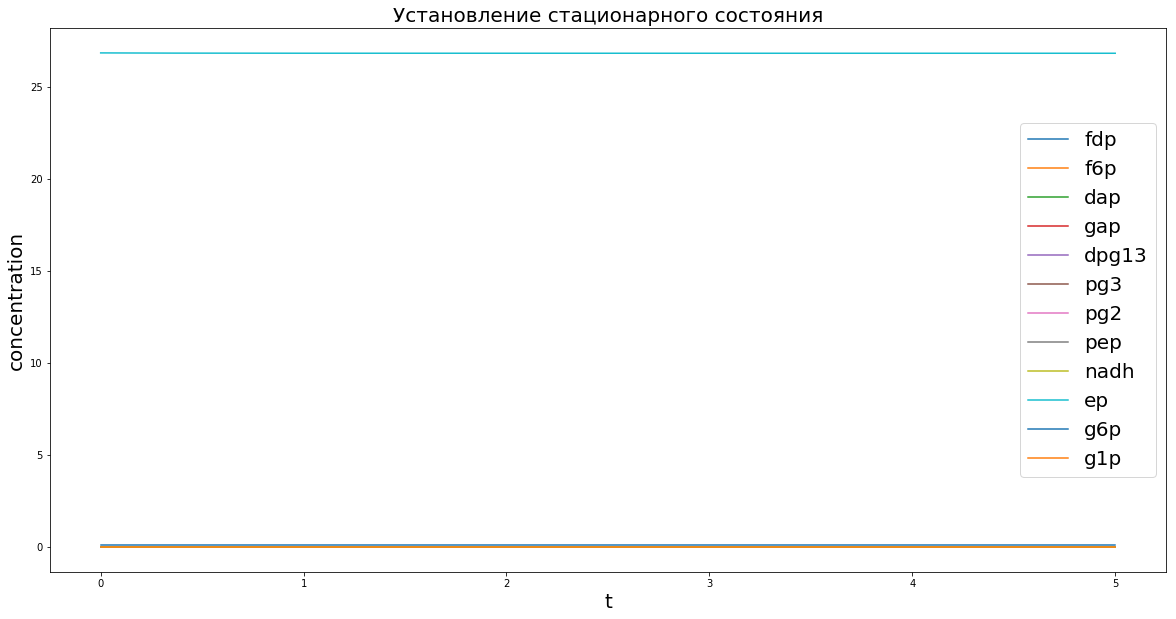

In [840]:
plt.figure(figsize = (20, 10))
plt.plot(t,fdp_1)
plt.plot(t,f6p_1)
plt.plot(t,dap_1)
plt.plot(t,gap_1)
plt.plot(t,dpg13_1)
plt.plot(t,pg3_1)
plt.plot(t,pg2_1)
plt.plot(t,pep_1)
plt.plot(t,nadh_1)
plt.plot(t,ep_1)
plt.plot(t,g6p_1)
plt.plot(t,g1p_1)
plt.legend(['fdp',\
            'f6p', \
            'dap', \
            'gap', \
            'dpg13', \
            'pg3', \
            'pg2', \
            'pep', \
            'nadh', \
            'ep',\
            'g6p',\
            'g1p'], fontsize = 20)
plt.title('Установление стационарного состояния', size = 20)
plt.xlabel('t', size = 20)
#plt.xlim(8, 10)
#plt.ylim(0, 5)
plt.ylabel('concentration', size = 20)
plt.show()

In [841]:
g6p_1[:3]

array([0.0897465 , 0.08974498, 0.08974232])

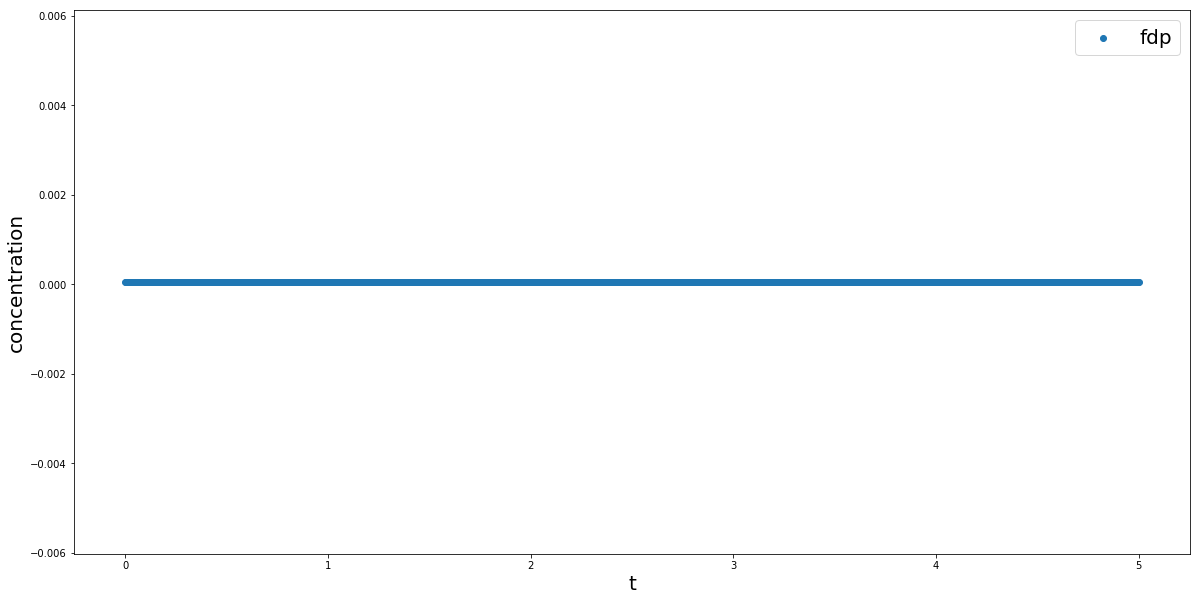

In [842]:
plt.figure(figsize = (20, 10))
plt.scatter(t,fdp_1[:1000])
plt.xlabel('t', size = 20)
#plt.xlim(8, 10)
#plt.ylim(0, 5)
plt.ylabel('concentration', size = 20)
plt.legend(['fdp'], fontsize = 20)
plt.show()

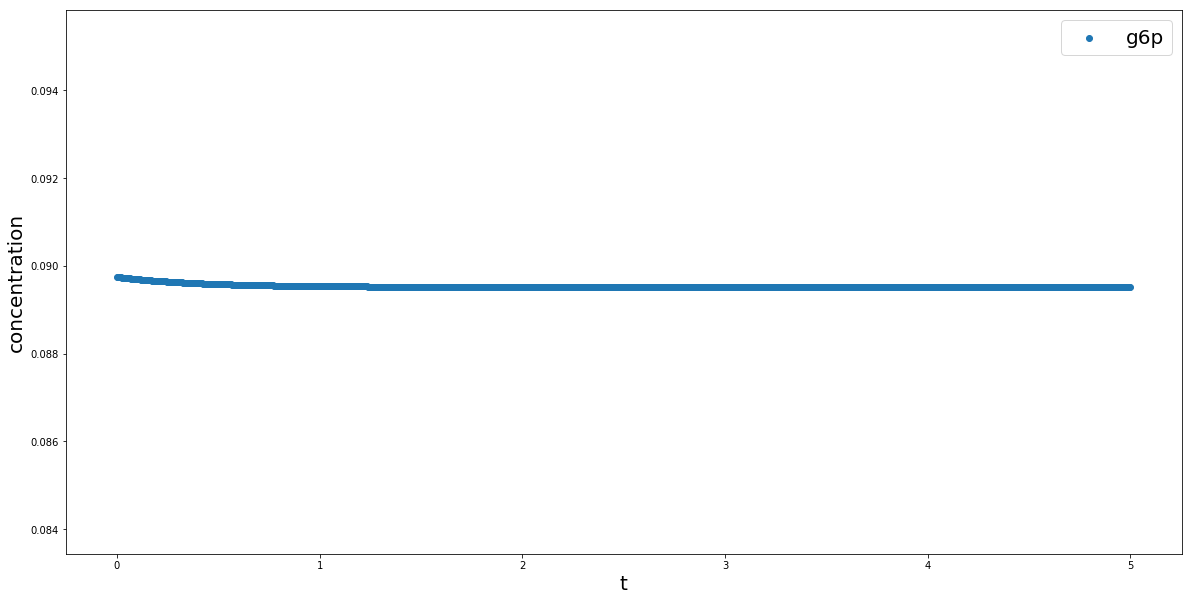

In [843]:
plt.figure(figsize = (20, 10))
plt.scatter(t,g6p_1[:1000])
plt.xlabel('t', size = 20)
#plt.xlim(8, 10)
#plt.ylim(0, 5)
plt.ylabel('concentration', size = 20)
plt.legend(['g6p'], fontsize = 20)
plt.show()

In [844]:
g1p_1[:3]

array([0.0052792 , 0.00527912, 0.00527896])

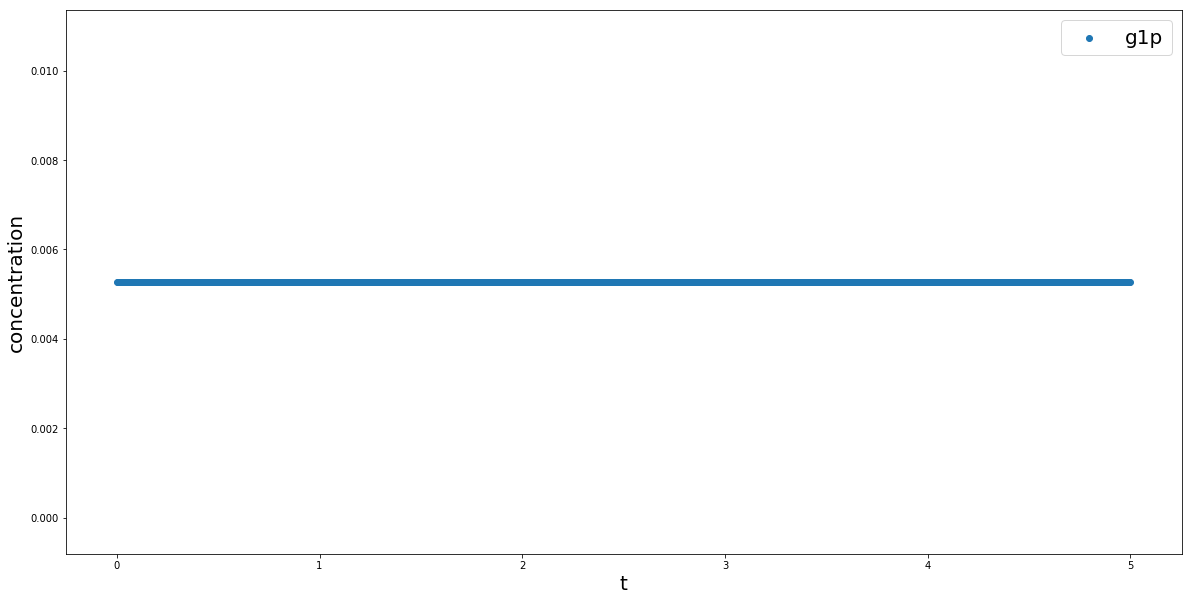

In [845]:
plt.figure(figsize = (20, 10))
plt.scatter(t,g1p_1[:1000])
plt.xlabel('t', size = 20)
#plt.xlim(8, 10)
#plt.ylim(0, 5)
plt.ylabel('concentration', size = 20)
plt.legend(['g1p'], fontsize = 20)
plt.show()

In [846]:
print(f6p_1[-1],
fdp_1[-1], 
dap_1[-1], 
gap_1[-1], 
dpg13_1[-1], 
pg3_1[-1], 
pg2_1[-1], 
pep_1[-1] ,
nadh_1[-1],
ep_1[-1],
g6p_1[-1],
g1p_1[-1])

0.02490338225557684 5.2519513883278984e-05 0.001503865731762591 0.000439984225205657 1.903458093312766e-05 0.0010279899008012329 0.0002317756535482276 0.000982660197298257 0.0019416694646328374 26.825550397127028 0.08952021881437999 0.005265895224376666


In [847]:
res[-1]

array([2.49033823e-02, 5.25195139e-05, 1.50386573e-03, 4.39984225e-04,
       1.90345809e-05, 1.02798990e-03, 2.31775654e-04, 9.82660197e-04,
       1.94166946e-03, 2.68255504e+01, 8.95202188e-02, 5.26589522e-03])

# GPa = 0

In [848]:
# g6p = 0.30137560977172045 
# f6p = 0.09699740878309336 
# fdp = 1.681927895780104e-05 
# dap = 0.0006477526431123148 
# gap = 0.00019676934308527575 
# dpg13 = 5.708499848996776e-05 
# pg3 = 0.001028280383987244 
# pg2 = 0.00024079716081047312
# pep = 0.0011331435498463664 
# pyr, lac = 70e-3, 1.2
# po4 = 5.5352930915504075
# nad_0, nadh = 50e-3, 0.0019372123810045777  
# g1p = 0.017727977037540997
# atp, amp = 5.077755490508499, 0.011966883480753924

In [849]:
# # значения при 99% пула
# f6p = 7.90143236e-02 #0.08
# fdp =5.30893074e-05  #0.00005
# dap = 2.13433960e-03  #0.002
# gap = 8.48596924e-04  #0.0008
# dpg13 = 4.53627463e-05
# pg3 = 1.00580513e-03
# pg2 =2.34345627e-04
# pep = 1.08843730e-03
# nadh = 1.93523193e-03 
# g6p = 2.47948634e-01
# g1p = 1.45852137e-02 
# atp = 5.01683694e+00
# #adp = 0.679019
# amp = 1.80949132e-02 
# po4 =7.01796161e-01 
# #Vprod = 24.653618

In [850]:
# значения при 90% пула
f6p = 0.0249826


fdp = 0.0000524
dap = 0.0015028
gap = 0.0004399
dpg13 = 0.0000191
pg3 = 0.0010280
pg2 = 0.0002318
pep = 0.0009831
nadh = 0.0019393
g6p = 0.0897465
g1p = 0.0052792

atp = 4.5435135
adp = 0.6884099
amp = 0.1043043
po4 = 7.2642201

In [851]:
y = [f6p, fdp, dap, gap, dpg13, pg3, pg2, pep, nadh, ep, g6p, g1p]

In [852]:
a_gp_a = 0
#y = res[-1]
t = np.linspace(0,2,1000)
res = odeint(right_part,y,t, printmessg = True)

In [853]:
y

[0.0249826,
 5.24e-05,
 0.0015028,
 0.0004399,
 1.91e-05,
 0.001028,
 0.0002318,
 0.0009831,
 0.0019393,
 26.8444170046047,
 0.0897465,
 0.0052792]

In [854]:
f6p = np.array(res)[:,0]
fdp = np.array(res)[:,1]
dap = np.array(res)[:,2]
gap = np.array(res)[:,3]
dpg13 = np.array(res)[:,4]
pg3 = np.array(res)[:,5]
pg2 = np.array(res)[:,6]
pep = np.array(res) [:,7]
nadh = np.array(res)[:,8]
ep = np.array(res)[:,9]
g6p = np.array(res)[:,10]
g1p = np.array(res)[:,11]

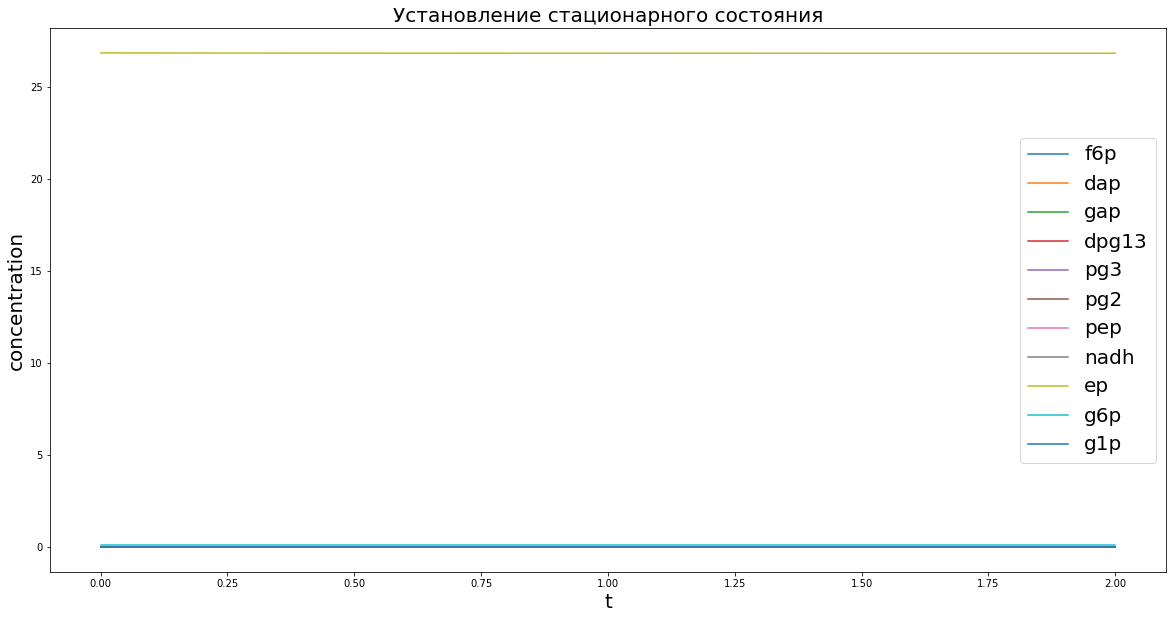

In [855]:
plt.figure(figsize = (20, 10))
#plt.plot(t,fdp)
plt.plot(t,f6p)
plt.plot(t,dap)
plt.plot(t,gap)
plt.plot(t,dpg13)
plt.plot(t,pg3)
plt.plot(t,pg2)
plt.plot(t,pep)
plt.plot(t,nadh)
plt.plot(t,ep)
plt.plot(t,g6p)
plt.plot(t,g1p)
plt.legend([\
            #'fdp',\
            'f6p', \
            'dap', \
            'gap', \
            'dpg13', \
            'pg3', \
            'pg2', \
            'pep', \
            'nadh', \
            'ep',\
            'g6p',\
            'g1p'], fontsize = 20)
plt.title('Установление стационарного состояния', size = 20)
plt.xlabel('t', size = 20)
#plt.xlim(8, 10)
#plt.ylim(0, 5)
plt.ylabel('concentration', size = 20)
plt.show()

# GPa = 5000

In [856]:
a_gp_a = 5000
y1 = res[-1]
t1 = np.linspace(2,4,1000)
res1 = odeint(right_part,y1,t1, printmessg = True)

In [857]:
res[-1]

array([2.49039306e-02, 5.25189043e-05, 1.50385556e-03, 4.39982153e-04,
       1.90348705e-05, 1.02799037e-03, 2.31775924e-04, 9.82663399e-04,
       1.94166939e-03, 2.68256807e+01, 8.95217891e-02, 5.26598759e-03])

In [858]:
f6p = np.append(f6p, np.array(res1)[:, 0])
fdp = np.append(fdp, np.array(res1)[:, 1])
dap = np.append(dap, np.array(res1)[:, 2])
gap = np.append(gap, np.array(res1)[:, 3])
dpg13 = np.append(dpg13, np.array(res1)[:, 4])
pg3 = np.append(pg3, np.array(res1)[:, 5])
pg2 = np.append(pg2, np.array(res1)[:, 6])
pep = np.append(pep, np.array(res1)[:, 7])
nadh = np.append(nadh, np.array(res1)[:, 8])
ep = np.append(ep, np.array(res1)[:, 9])
g6p = np.append(g6p, np.array(res1)[:, 10])
g1p = np.append(g1p, np.array(res1)[:, 11])

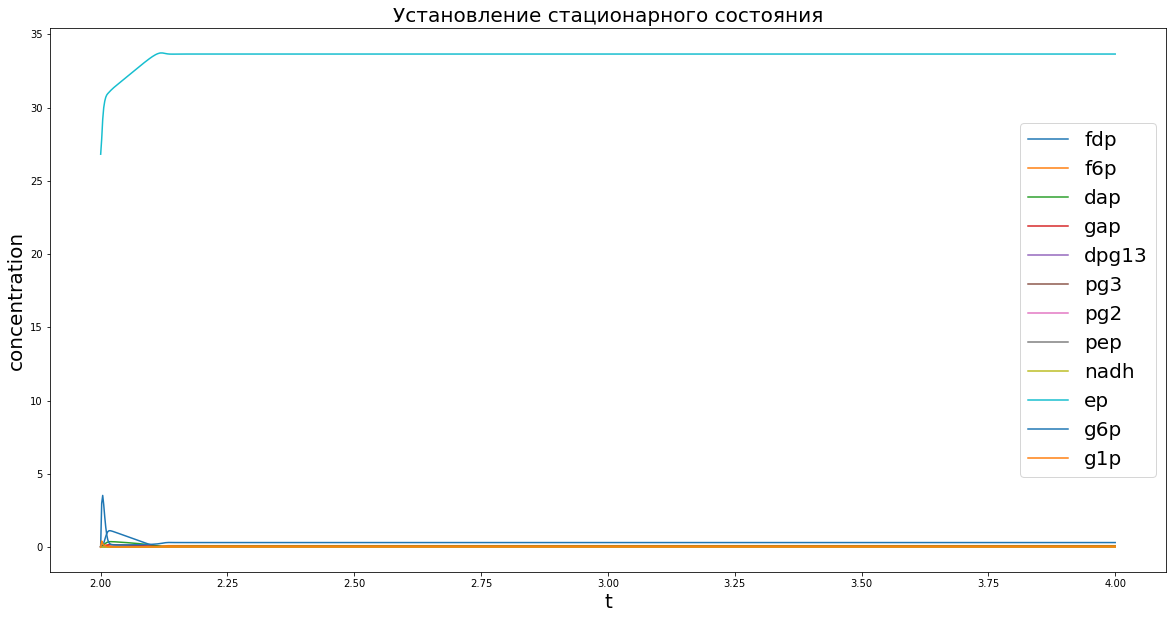

In [859]:
plt.figure(figsize = (20, 10))
plt.plot(t1,fdp[-1000:])
plt.plot(t1,f6p[-1000:])
plt.plot(t1,dap[-1000:])
plt.plot(t1,gap[-1000:])
plt.plot(t1,dpg13[-1000:])
plt.plot(t1,pg3[-1000:])
plt.plot(t1,pg2[-1000:])
plt.plot(t1,pep[-1000:])
plt.plot(t1,nadh[-1000:])
plt.plot(t1,ep[-1000:])
plt.plot(t1,g6p[-1000:])
plt.plot(t1,g1p[-1000:])
plt.legend(['fdp',\
            'f6p', \
            'dap', \
            'gap', \
            'dpg13', \
            'pg3', \
            'pg2', \
            'pep', \
            'nadh', \
            'ep',\
            'g6p',\
            'g1p'], fontsize = 20)
plt.title('Установление стационарного состояния', size = 20)
plt.xlabel('t', size = 20)
#plt.xlim(8, 10)
#plt.ylim(0, 5)
plt.ylabel('concentration', size = 20)
plt.show()

# GPa = 0

In [860]:
a_gp_a = 0
y2 = res1[-1]
t2 = np.linspace(4,8,1000)
res2 = odeint(right_part,y2,t2)

In [861]:
f6p = np.append(f6p, np.array(res2)[:, 0])
fdp = np.append(fdp, np.array(res2)[:, 1])
dap = np.append(dap, np.array(res2)[:, 2])
gap = np.append(gap, np.array(res2)[:, 3])
dpg13 = np.append(dpg13, np.array(res2)[:, 4])
pg3 = np.append(pg3, np.array(res2)[:, 5])
pg2 = np.append(pg2, np.array(res2)[:, 6])
pep = np.append(pep, np.array(res2)[:, 7])
nadh = np.append(nadh, np.array(res2)[:, 8])
ep = np.append(ep, np.array(res2)[:, 9])
g6p = np.append(g6p, np.array(res2)[:, 10])
g1p = np.append(g1p, np.array(res2)[:, 11])

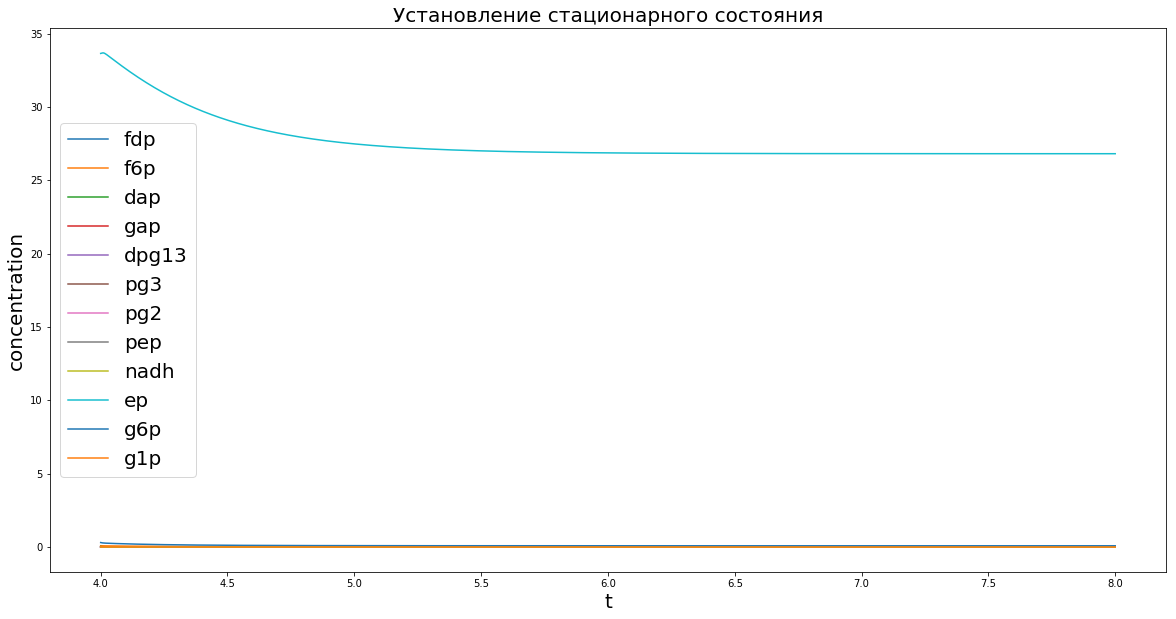

In [862]:
plt.figure(figsize = (20, 10))
plt.plot(t2,fdp[-1000:])
plt.plot(t2,f6p[-1000:])
plt.plot(t2,dap[-1000:])
plt.plot(t2,gap[-1000:])
plt.plot(t2,dpg13[-1000:])
plt.plot(t2,pg3[-1000:])
plt.plot(t2,pg2[-1000:])
plt.plot(t2,pep[-1000:])
plt.plot(t2,nadh[-1000:])
plt.plot(t2,ep[-1000:])
plt.plot(t2,g6p[-1000:])
plt.plot(t2,g1p[-1000:])
plt.legend(['fdp',\
            'f6p', \
            'dap', \
            'gap', \
            'dpg13', \
            'pg3', \
            'pg2', \
            'pep', \
            'nadh', \
            'ep',\
            'g6p',\
            'g1p'], fontsize = 20)
plt.title('Установление стационарного состояния', size = 20)
plt.xlabel('t', size = 20)
#plt.xlim(8, 10)
#plt.ylim(0, 5)
plt.ylabel('concentration', size = 20)
plt.show()

In [863]:
t0 = np.concatenate((t, t1, t2), axis=0)

In [864]:
atp_t = []
adp_t = []
amp_t = []
po4_t = []
crp_t = []

v_pfk_t = []
v_hk_t = []
v_pgk_t = []
v_pk_t = []

for ix, t in enumerate(t0):
    
    nad = nad_0 - nadh[ix]
    po4_up = g1p[ix] + g6p[ix] + f6p[ix] + 2*fdp[ix] + dap[ix] + gap[ix]
    po4_down = 2*dpg13[ix] + pg3[ix] + pg2[ix] + pep[ix]
    po4 = po4_0 - ( po4_up + po4_down + ep[ix])
    crp = float(my_cubic_solve(coefficients(ep[ix], c_0, p_0, k_ak, k_ck)))
    atp, adp, amp, cr = tdmc(crp, c_0, p_0, k_ak, k_ck)
    atp_t.append(atp)
    adp_t.append(adp)
    amp_t.append(amp)
    po4_t.append(po4)
    crp_t.append(crp)
    
    v_pfk_t.append(u_pfk(a_pfk, atp, amp, f6p[ix]))
    v_hk_t.append(u_hk(a_hk, atp, g6p[ix]))
    v_pgk_t.append(u_pgk(a_pgk * ACT, dpg13[ix], adp, pg3[ix], atp))
    v_pk_t.append(u_pk(a_pk * ACT, pep[ix], adp, atp))

In [865]:
adp_t[950]

0.6896987077992578

In [866]:
print(f6p[950],
fdp[950], 
dap[950], 
gap[950], 
dpg13[950], 
pg3[950], 
pg2[950], 
pep[950] ,
nadh[950],
ep[950],
g6p[950],
g1p[950])

0.02490408214900319 5.251873586057269e-05 0.0015038527540345388 0.0004399815802629264 1.9034950472873944e-05 0.0010279905033259845 0.0002317759991653652 0.0009826642832715116 0.0019416693643579106 26.8257166835745 0.08952222288308037 0.005266013112794924


In [867]:
print(f6p[0],
fdp[0], 
dap[0], 
gap[0], 
dpg13[0], 
pg3[0], 
pg2[0], 
pep[0] ,
nadh[0],
ep[0],
g6p[0],
g1p[0])

0.0249826 5.24e-05 0.0015028 0.0004399 1.91e-05 0.001028 0.0002318 0.0009831 0.0019393 26.8444170046047 0.0897465 0.0052792


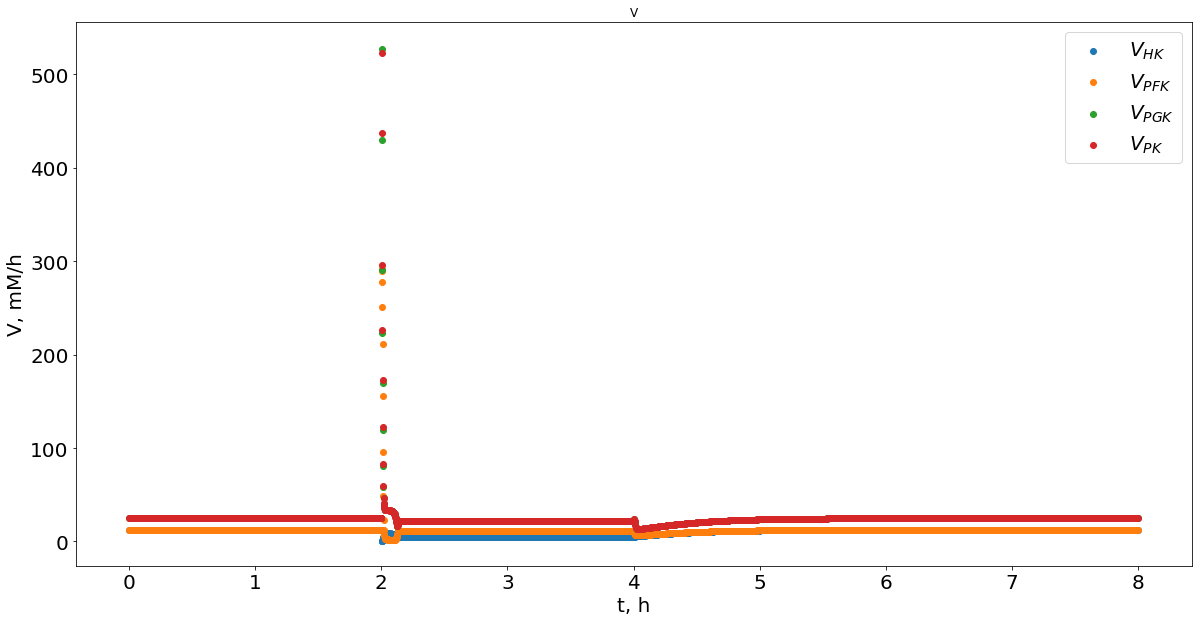

In [868]:
plt.figure(figsize = (20, 10))
plt.scatter(t0[1:],v_hk_t[1:])
plt.scatter(t0[1:],v_pfk_t[1:])
plt.scatter(t0[1:],v_pgk_t[1:])
plt.scatter(t0[1:],v_pk_t[1:])
# plt.scatter(atp_p,np.array(v_pk_atp))

plt.title('V')
plt.xlabel('t, h', fontsize = 20)
plt.ylabel('V, mM/h', fontsize = 20)
plt.legend(['$V_{HK}$',\
            '$V_{PFK}$',\
            '$V_{PGK}$',\
            '$V_{PK}$',\
            ], fontsize = 20)
plt.xticks(size = 20)
plt.yticks(size = 20)
#plt.xlim(0, 5.5)
#plt.ylim(0, 25)
plt.show()

In [869]:
v_production_t = []
for ix, t in enumerate(t0):
    v_production_t.append(-v_hk_t[ix] - v_pfk_t[ix] + v_pgk_t[ix] + v_pk_t[ix])

In [883]:
v_production_t[1001:1006]

[760.0365773189149,
 574.2631666790286,
 308.2215837712627,
 198.24105038475048,
 129.80543140351747]

In [884]:
t0[1001:1006]

array([2.002002  , 2.004004  , 2.00600601, 2.00800801, 2.01001001])

In [871]:
# t0 = list(t0)
# del t0[1001:1061]
# del v_production_t[1001:1061]
# t0 = np.array(t0)

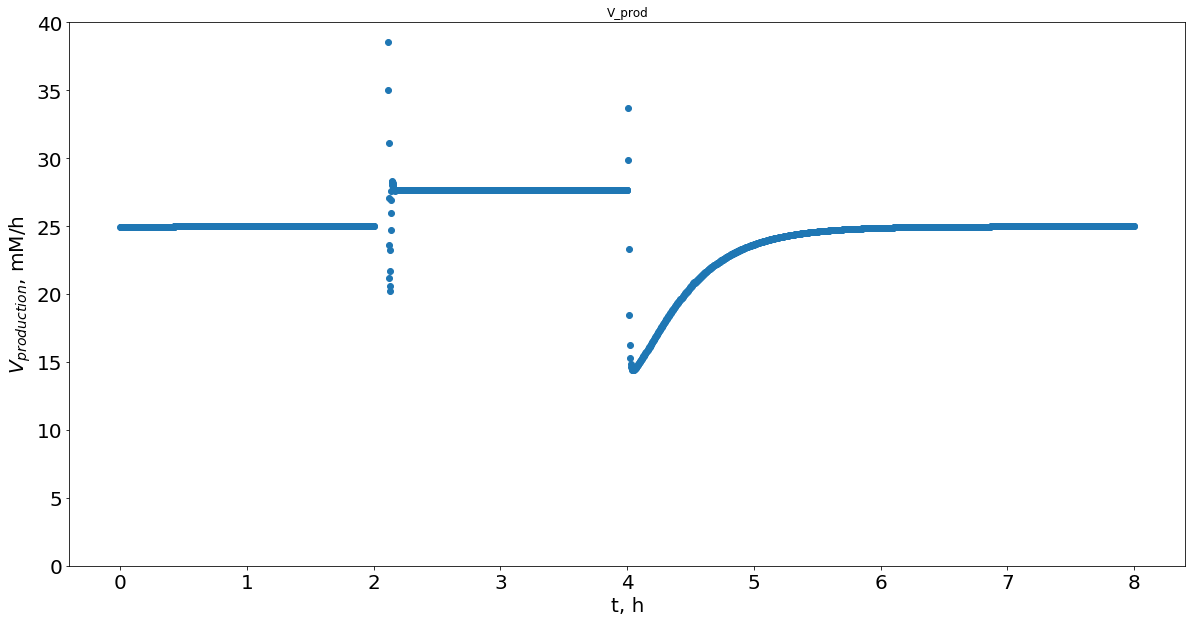

In [872]:
plt.figure(figsize = (20, 10))
plt.scatter(t0[1:],v_production_t[1:])
# plt.scatter(atp_p,np.array(v_pk_atp))

plt.title('V_prod')
plt.xlabel('t, h', fontsize = 20)
plt.ylabel('$V_{production}$, mM/h', fontsize = 20)
#plt.legend(['a_gpa = 0', 'a_gpa = 5000', 'a_gpa = 0'])
plt.xticks(size = 20)
plt.yticks(size = 20)
#plt.xlim(0, 25)
plt.ylim(0, 40)
plt.show()

In [873]:
print(f6p[999],
fdp[999], 
dap[999], 
gap[999], 
dpg13[999], 
pg3[999], 
pg2[999], 
pep[999] ,
nadh[999],
ep[999],
g6p[999],
g1p[999],
     atp_t[999],
     crp_t[999])

0.02490393064499036 5.251890427406177e-05 0.0015038555632333475 0.00043998215279149864 1.9034870479712154e-05 0.0010279903728965516 0.0002317759243505583 0.0009826633987990432 0.0019416693860638506 26.825680688420785 0.089521789067492 0.005265987593792697 4.541790644336666 17.052398209883528


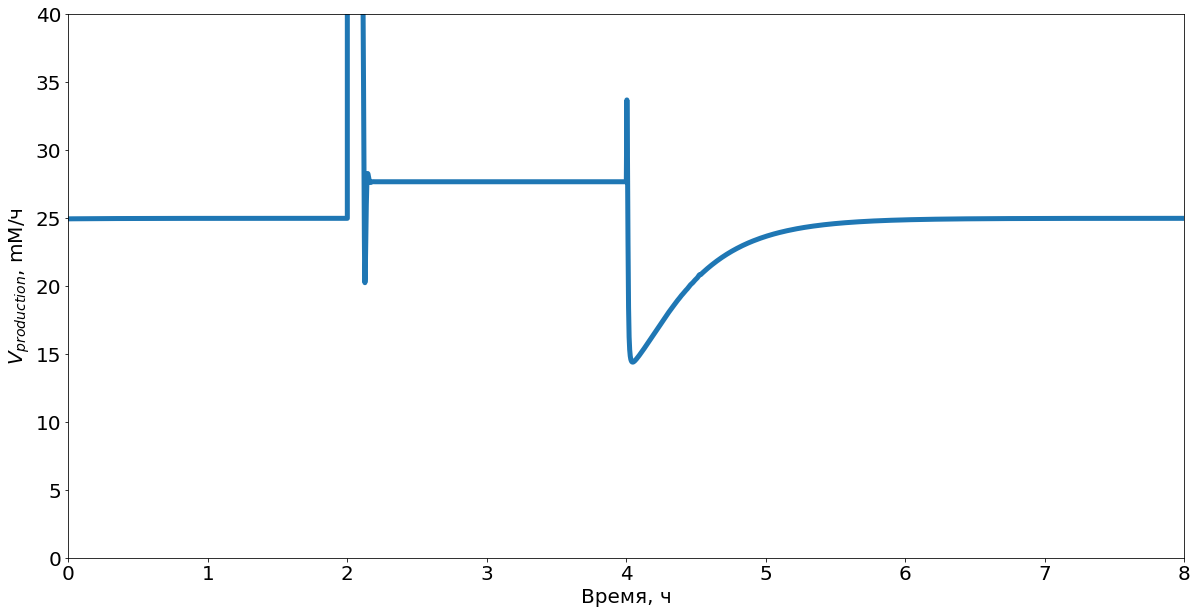

In [949]:
plt.figure(figsize = (20, 10))
plt.plot(t0[1:],v_production_t[1:], linewidth = 5)
# plt.scatter(atp_p,np.array(v_pk_atp))

#plt.title('V_prod')
plt.xlabel('Время, ч', fontsize = 20)
plt.ylabel('$V_{production}$, mM/ч', fontsize = 20)
#plt.legend(['a_gpa = 0', 'a_gpa = 5000', 'a_gpa = 0'])
plt.xticks(size = 20)
plt.yticks(size = 20)
plt.xlim(0, 8)
plt.ylim(0, 40)
plt.show()

In [879]:
# !pip install brokenaxes

In [880]:
from brokenaxes import brokenaxes

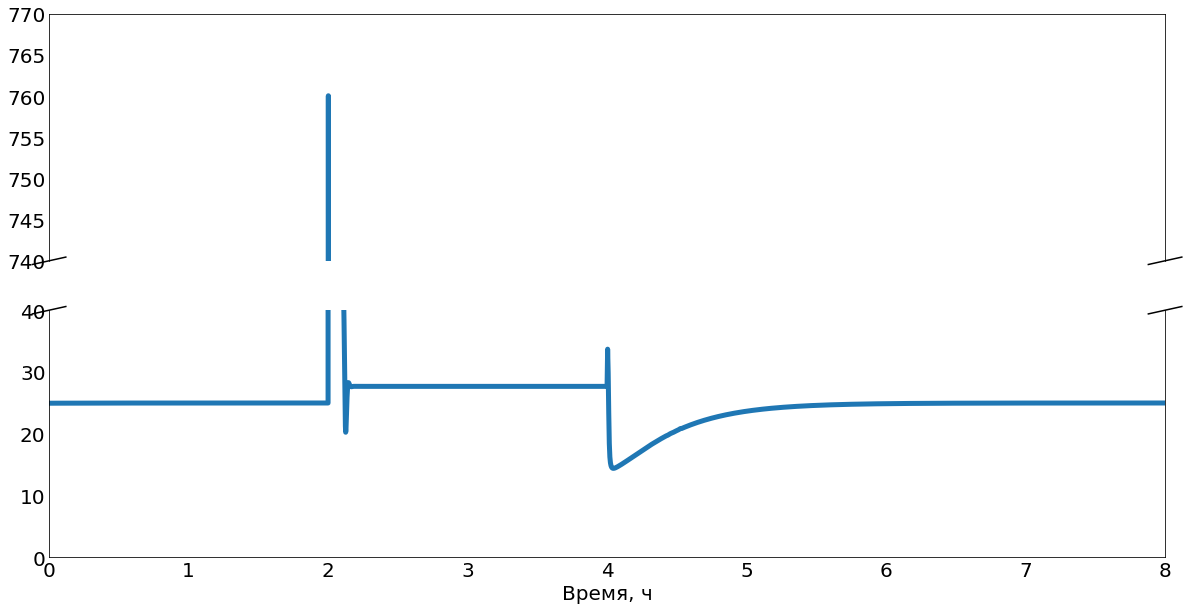

In [950]:
fig,(ax,ax2) = plt.subplots(2, 1, sharey=False ,figsize = (20, 10))

# plot the same data on both axes
ax.plot(t0[1:],v_production_t[1:], linewidth = 5)
ax2.plot(t0[1:],v_production_t[1:], linewidth = 5)

# zoom-in / limit the view to different portions of the data
ax.set_ylim(740,770) # most of the data
ax2.set_ylim(0, 40) # outliers only
ax.set_xlim(0,8) # most of the data
ax2.set_xlim(0, 8) # outliers only

# hide the spines between ax and ax2
ax.spines['bottom'].set_visible(False)
ax2.spines['top'].set_visible(False)
# ax.yaxis.tick_top()
ax.tick_params(labelbottom='off') # don't put tick labels at the top
ax2.xaxis.tick_bottom()
ax.tick_params(size = 0, labelsize=20)
ax2.tick_params(size = 0, labelsize=20)

d = .015 # how big to make the diagonal lines in axes coordinates
# arguments to pass plot, just so we don't keep repeating them
kwargs = dict(transform=ax.transAxes, color='k', clip_on=False)
ax.plot((1-d,1+d),(-d,+d), **kwargs) # top-left diagonal
ax.plot((-d,+d),(-d,+d), **kwargs) # bottom-left diagonal

kwargs.update(transform=ax2.transAxes) # switch to the bottom axes
ax2.plot((1-d,1+d),(1-d,1+d), **kwargs) # top-right diagonal
ax2.plot((-d,d),(1-d,1+d), **kwargs) # bottom-right diagonal

# Make the spacing between the two axes a bit smaller
plt.subplots_adjust(wspace=0.15)

plt.xlabel('Время, ч', fontsize = 20)
# plt.ylabel('$V_{production}$, mM/ч', fontsize = 20)


plt.show()

In [819]:
# t_0 = t0

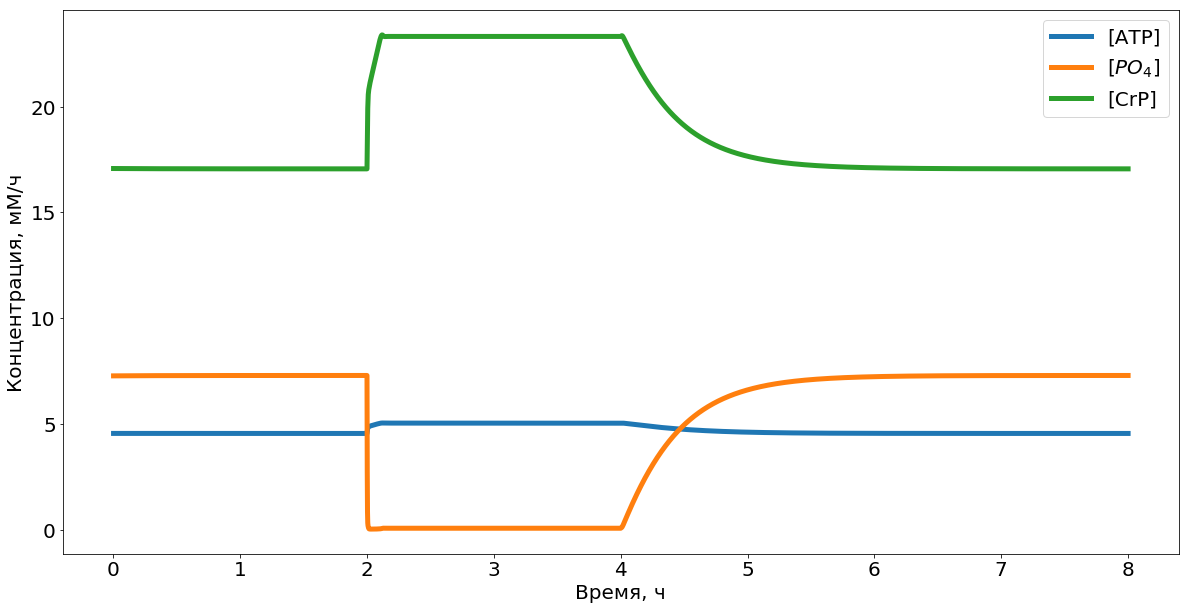

In [829]:
plt.figure(figsize = (20, 10))
plt.plot(t_0[1:],atp_t[1:], linewidth = 5)
plt.plot(t_0[1:],po4_t[1:], linewidth = 5)
plt.plot(t_0[1:],crp_t[1:], linewidth = 5)

# plt.title('[ATP], [PO4], [CrP]')
plt.xlabel('Время, ч', fontsize = 20)
plt.ylabel('Концентрация, мM/ч', fontsize = 20)
plt.legend(['[ATP]', '[$PO_4$]', '[CrP]'], fontsize = 20)
plt.xticks(size = 20)
plt.yticks(size = 20)
#plt.xlim(0, 5.5)
#plt.ylim(0, 5)
plt.show()